# Facial Emotion Recognition Experiments

In this notebook, we will conduct experiments to train models on facial emotion recognition data. The dataset used here is a [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013), which is a challenging due to its imbalance and small image size (48x38 pixels). The goal of these experiments is to identify which pre-trained model performs best for this task.

In this notebook, all the pretrained models will be used as fixed feature extractors, meaning that all pre-trained layers will be frozen, and only the fully connected layers will be trained.We will explore several models, including:
* **CNN-based models** like `resnet18`, `vgg16` and `densenet121`
* **Vision Transformers (ViT) model** such as `vit_b_16`
* **CLIP model** `ViT-B/32`.

These models will be evaluated to determine the most effective approach for categorizing facial expressions into seven emotion categories.

At the end of the experiments, we will compare and visualize the accuracy of each model on the test data as well as their respective training times.
* For training, NVIDA GeForce GTX 1070 Ti is used.
* Finally, we will compare the performance of all models, their accuracy on test dataset and training time.

## Imports and Setup

In [2]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

**Device agnostic code**

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1070 Ti


In [7]:
!nvidia-smi

Tue Oct 15 16:53:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8             11W /  180W |       0MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Overview

* [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset is used, which is of **63** MB.
* The dataset consists of 48x48 pixel grayscale images of faces, categorized into seven emotions. 
* The data is organized into training and testing sets with subfolders representing each emotion.

```bash
data
 |- train
    |- angry
    |- disgust
    |- fear
    |- happy
    |- neutral
    |- sad
    |- surprise
 |- test
    |- angry
    |- disgust
    |- fear
    |- happy
    |- neutral
    |- sad
    |- surprise
```

## Data Loading and Visualization

### Loading the Dataset
We'll use `ImageFolder` from `torchvision.datasets` to load the data. Since the images are grayscale, it will be convert to RGB by duplicating the single channel to match the pretrained models' expected input.

In [8]:
data_dir = './data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

**Define transformations**

In [9]:
# Pretrained models expect images of size at least 224x224 and 3 channels
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Using ImageNet means
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [10]:
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

**Split the train set into train and validation sets**  

Since we have no predefined validation set in our dataset. So we'll split train dataset into separate train and validation subsets. This allows us to monitor the model's performance during training.

1. **Split the Training Dataset**  
    * We'll split the original training dataset into a new training set and a validation set.  
    **Split Ratios**  
        - **Training Set Ratio**: ~69.9%  
        - **Validation Set Ratio**: ~10.0%  
        - **Test Set Ratio**: ~20.0%  
    * Dataset is split into approximately 70% training, 10% validation, and 20% test.

In [11]:
# Define the size for training and validation sets
train_size = int(0.875 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

In [12]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [13]:
val_dataset.dataset.transform = data_transforms['val']

In [14]:
# Load the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

**Create DataLoader**

In [15]:
batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

In [16]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
class_names = full_train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")
print(f"Testing samples: {dataset_sizes['test']}")

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Training samples: 25120
Validation samples: 3589
Testing samples: 7178


## Visualizing the Dataset


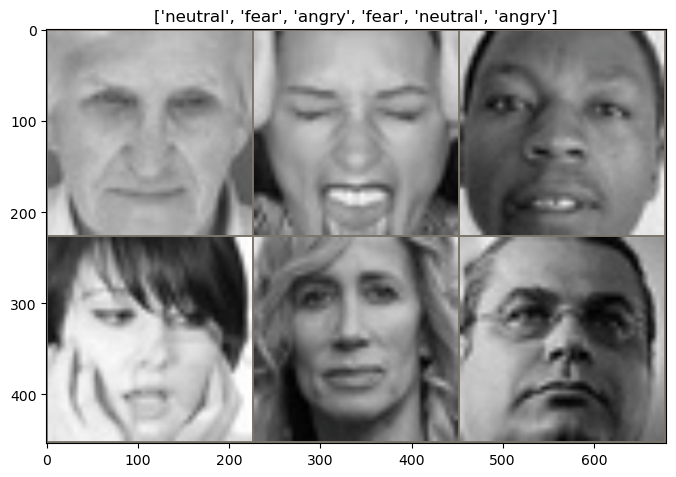

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

inputs, classes = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True)))
out = torchvision.utils.make_grid(inputs, nrow=3)

# Visualize images with corresponding labels
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])
plt.show()

## Utility Functions
* Define utility functions for training, evaluating, plotting, and tracking training time.

In [19]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15):
    since = time.time()

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track gradients only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed

In [21]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Test Accuracy: {acc:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('Actual', fontsize=14, color='navy')
    plt.xlabel('Predicted', fontsize=14, color='navy')
    plt.title('Confusion Matrix', fontsize=18, fontweight='bold', color='navy')
    plt.show()

    return acc

## Model Training and Evaluation
We'll experiment with three categories of models:

1. **Pretrained CNN-based Models** like `resnet18`, `vgg16` and `densenet121`
2. **Vision Transformer (ViT) Model** such as `vit_b_16`
3. **CLIP Models** `ViT-B/32`

For each category, we'll:

* Initialize the model
* Modify the final layer to match our number of classes
* Define loss and optimizer
* Train the model
* Evaluate and save results

### Pretrained CNN Models

#### Resnet18

In [20]:
# Initialize ResNet18
model_resnet = models.resnet18(pretrained=True)

In [21]:
# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)

**Train the model**

In [22]:
# start_time = time.time()
model_resnet, history_resnet, train_time_resnet18 = train_model(
    model_resnet, dataloaders, criterion, optimizer_resnet, num_epochs=20
)
end_time = time.time()
# total_time_resnet18 = print_train_time(start_time, end_time, device=device)

Epoch 1/20
----------


train:   0%|          | 0/393 [00:00<?, ?it/s]

train: 100%|██████████| 393/393 [07:12<00:00,  1.10s/it]


Train Loss: 1.7878 Acc: 0.2647


val: 100%|██████████| 57/57 [01:05<00:00,  1.14s/it]


Val Loss: 1.7213 Acc: 0.3123

Epoch 2/20
----------


train: 100%|██████████| 393/393 [01:04<00:00,  6.12it/s]


Train Loss: 1.6778 Acc: 0.3391


val: 100%|██████████| 57/57 [00:25<00:00,  2.20it/s]


Val Loss: 1.6480 Acc: 0.3619

Epoch 3/20
----------


train: 100%|██████████| 393/393 [01:08<00:00,  5.72it/s]


Train Loss: 1.6201 Acc: 0.3729


val: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Val Loss: 1.6062 Acc: 0.3842

Epoch 4/20
----------


train: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]


Train Loss: 1.5836 Acc: 0.3924


val: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Val Loss: 1.5779 Acc: 0.3892

Epoch 5/20
----------


train: 100%|██████████| 393/393 [01:04<00:00,  6.14it/s]


Train Loss: 1.5592 Acc: 0.4021


val: 100%|██████████| 57/57 [00:27<00:00,  2.10it/s]


Val Loss: 1.5579 Acc: 0.4007

Epoch 6/20
----------


train: 100%|██████████| 393/393 [01:02<00:00,  6.28it/s]


Train Loss: 1.5406 Acc: 0.4127


val: 100%|██████████| 57/57 [00:25<00:00,  2.23it/s]


Val Loss: 1.5427 Acc: 0.4099

Epoch 7/20
----------


train: 100%|██████████| 393/393 [01:04<00:00,  6.14it/s]


Train Loss: 1.5243 Acc: 0.4200


val: 100%|██████████| 57/57 [00:25<00:00,  2.21it/s]


Val Loss: 1.5325 Acc: 0.4174

Epoch 8/20
----------


train: 100%|██████████| 393/393 [01:06<00:00,  5.95it/s]


Train Loss: 1.5119 Acc: 0.4251


val: 100%|██████████| 57/57 [00:28<00:00,  2.02it/s]


Val Loss: 1.5224 Acc: 0.4210

Epoch 9/20
----------


train: 100%|██████████| 393/393 [01:02<00:00,  6.28it/s]


Train Loss: 1.5013 Acc: 0.4291


val: 100%|██████████| 57/57 [00:23<00:00,  2.42it/s]


Val Loss: 1.5186 Acc: 0.4146

Epoch 10/20
----------


train: 100%|██████████| 393/393 [00:57<00:00,  6.84it/s]


Train Loss: 1.4948 Acc: 0.4293


val: 100%|██████████| 57/57 [00:23<00:00,  2.43it/s]


Val Loss: 1.5055 Acc: 0.4255

Epoch 11/20
----------


train: 100%|██████████| 393/393 [00:59<00:00,  6.64it/s]


Train Loss: 1.4874 Acc: 0.4320


val: 100%|██████████| 57/57 [00:24<00:00,  2.35it/s]


Val Loss: 1.5012 Acc: 0.4227

Epoch 12/20
----------


train: 100%|██████████| 393/393 [01:02<00:00,  6.34it/s]


Train Loss: 1.4807 Acc: 0.4367


val: 100%|██████████| 57/57 [00:24<00:00,  2.36it/s]


Val Loss: 1.4984 Acc: 0.4224

Epoch 13/20
----------


train: 100%|██████████| 393/393 [01:01<00:00,  6.41it/s]


Train Loss: 1.4765 Acc: 0.4402


val: 100%|██████████| 57/57 [00:24<00:00,  2.36it/s]


Val Loss: 1.4947 Acc: 0.4291

Epoch 14/20
----------


train: 100%|██████████| 393/393 [00:57<00:00,  6.83it/s]


Train Loss: 1.4693 Acc: 0.4426


val: 100%|██████████| 57/57 [00:23<00:00,  2.38it/s]


Val Loss: 1.4934 Acc: 0.4291

Epoch 15/20
----------


train: 100%|██████████| 393/393 [00:58<00:00,  6.70it/s]


Train Loss: 1.4661 Acc: 0.4432


val: 100%|██████████| 57/57 [00:24<00:00,  2.34it/s]


Val Loss: 1.4831 Acc: 0.4338

Epoch 16/20
----------


train: 100%|██████████| 393/393 [00:57<00:00,  6.84it/s]


Train Loss: 1.4620 Acc: 0.4462


val: 100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Val Loss: 1.4821 Acc: 0.4327

Epoch 17/20
----------


train: 100%|██████████| 393/393 [00:56<00:00,  6.92it/s]


Train Loss: 1.4583 Acc: 0.4473


val: 100%|██████████| 57/57 [00:23<00:00,  2.42it/s]


Val Loss: 1.4797 Acc: 0.4349

Epoch 18/20
----------


train: 100%|██████████| 393/393 [00:56<00:00,  6.98it/s]


Train Loss: 1.4565 Acc: 0.4460


val: 100%|██████████| 57/57 [00:23<00:00,  2.43it/s]


Val Loss: 1.4833 Acc: 0.4324

Epoch 19/20
----------


train: 100%|██████████| 393/393 [00:56<00:00,  6.91it/s]


Train Loss: 1.4509 Acc: 0.4488


val: 100%|██████████| 57/57 [00:23<00:00,  2.41it/s]


Val Loss: 1.4745 Acc: 0.4380

Epoch 20/20
----------


train: 100%|██████████| 393/393 [00:58<00:00,  6.67it/s]


Train Loss: 1.4486 Acc: 0.4482


val: 100%|██████████| 57/57 [00:23<00:00,  2.45it/s]

Val Loss: 1.4784 Acc: 0.4330

Training complete in 35m 27s
Best Validation Acc: 0.4380


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [01:00<00:00,  1.88it/s]


Test Accuracy: 0.4324


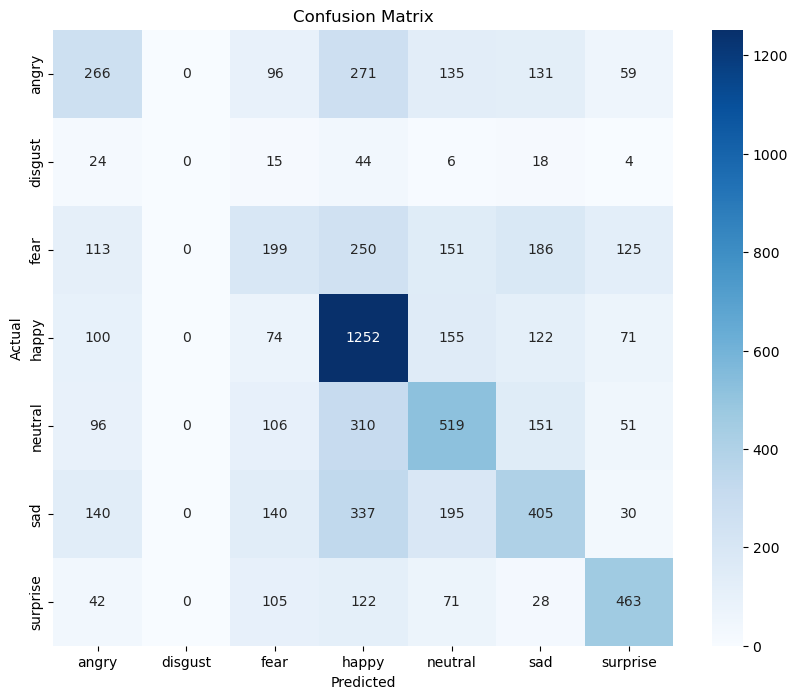

In [23]:
test_acc_resnet18 = evaluate_model(model_resnet, dataloaders['test'], class_names)

**Save the model**

In [25]:
torch.save(model_resnet.state_dict(), './models/resnet18_facial_emotion.pth')

**Plot learning curves**

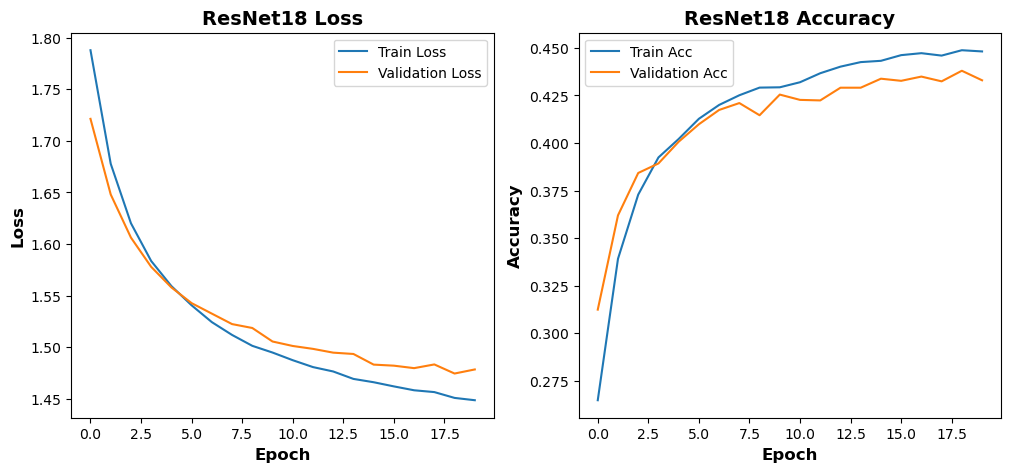

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_resnet['train_loss'], label='Train Loss')
plt.plot(history_resnet['val_loss'], label='Validation Loss')
plt.title('ResNet18 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet['train_acc'], label='Train Acc')
plt.plot(history_resnet['val_acc'], label='Validation Acc')
plt.title('ResNet18 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

#### VGG16

In [31]:
# Initialize VGG16
model_vgg = models.vgg16(pretrained=True)

In [32]:
# Freeze all the layers in VGG16
for param in model_vgg.parameters():
    param.requires_grad = False

num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg = model_vgg.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-4)

**Train the model**

In [33]:
model_vgg, history_vgg, train_time_vgg16 = train_model(
    model_vgg, dataloaders, criterion, optimizer_vgg, num_epochs=20
)

Epoch 1/20
----------


train: 100%|██████████| 393/393 [02:21<00:00,  2.77it/s]


Train Loss: 1.7262 Acc: 0.3036


val: 100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


Val Loss: 1.6032 Acc: 0.3820

Epoch 2/20
----------


train: 100%|██████████| 393/393 [02:23<00:00,  2.73it/s]


Train Loss: 1.6176 Acc: 0.3624


val: 100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


Val Loss: 1.5569 Acc: 0.4118

Epoch 3/20
----------


train: 100%|██████████| 393/393 [02:23<00:00,  2.74it/s]


Train Loss: 1.5823 Acc: 0.3824


val: 100%|██████████| 57/57 [00:36<00:00,  1.56it/s]


Val Loss: 1.5342 Acc: 0.4160

Epoch 4/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.81it/s]


Train Loss: 1.5626 Acc: 0.3944


val: 100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


Val Loss: 1.5169 Acc: 0.4296

Epoch 5/20
----------


train: 100%|██████████| 393/393 [02:27<00:00,  2.66it/s]


Train Loss: 1.5488 Acc: 0.3974


val: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Val Loss: 1.5073 Acc: 0.4319

Epoch 6/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.82it/s]


Train Loss: 1.5357 Acc: 0.4041


val: 100%|██████████| 57/57 [00:36<00:00,  1.55it/s]


Val Loss: 1.5010 Acc: 0.4338

Epoch 7/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.82it/s]


Train Loss: 1.5298 Acc: 0.4101


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4918 Acc: 0.4439

Epoch 8/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.81it/s]


Train Loss: 1.5256 Acc: 0.4116


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4896 Acc: 0.4419

Epoch 9/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.82it/s]


Train Loss: 1.5207 Acc: 0.4135


val: 100%|██████████| 57/57 [00:36<00:00,  1.57it/s]


Val Loss: 1.4875 Acc: 0.4450

Epoch 10/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.81it/s]


Train Loss: 1.5114 Acc: 0.4191


val: 100%|██████████| 57/57 [00:36<00:00,  1.55it/s]


Val Loss: 1.4801 Acc: 0.4478

Epoch 11/20
----------


train: 100%|██████████| 393/393 [02:20<00:00,  2.80it/s]


Train Loss: 1.5087 Acc: 0.4176


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4788 Acc: 0.4408

Epoch 12/20
----------


train: 100%|██████████| 393/393 [02:20<00:00,  2.80it/s]


Train Loss: 1.5071 Acc: 0.4179


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4756 Acc: 0.4505

Epoch 13/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.82it/s]


Train Loss: 1.5072 Acc: 0.4170


val: 100%|██████████| 57/57 [00:35<00:00,  1.61it/s]


Val Loss: 1.4740 Acc: 0.4388

Epoch 14/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.82it/s]


Train Loss: 1.5065 Acc: 0.4188


val: 100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


Val Loss: 1.4778 Acc: 0.4355

Epoch 15/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.82it/s]


Train Loss: 1.4973 Acc: 0.4218


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4677 Acc: 0.4547

Epoch 16/20
----------


train: 100%|██████████| 393/393 [02:20<00:00,  2.80it/s]


Train Loss: 1.4966 Acc: 0.4217


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4705 Acc: 0.4478

Epoch 17/20
----------


train: 100%|██████████| 393/393 [02:19<00:00,  2.81it/s]


Train Loss: 1.4976 Acc: 0.4217


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4713 Acc: 0.4425

Epoch 18/20
----------


train: 100%|██████████| 393/393 [02:20<00:00,  2.79it/s]


Train Loss: 1.4903 Acc: 0.4282


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4675 Acc: 0.4444

Epoch 19/20
----------


train: 100%|██████████| 393/393 [02:20<00:00,  2.80it/s]


Train Loss: 1.4956 Acc: 0.4211


val: 100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Val Loss: 1.4652 Acc: 0.4478

Epoch 20/20
----------


train: 100%|██████████| 393/393 [02:20<00:00,  2.80it/s]


Train Loss: 1.4922 Acc: 0.4230


val: 100%|██████████| 57/57 [00:36<00:00,  1.56it/s]

Val Loss: 1.4662 Acc: 0.4441

Training complete in 59m 2s
Best Validation Acc: 0.4547


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:51<00:00,  2.18it/s]


Test Accuracy: 0.4446


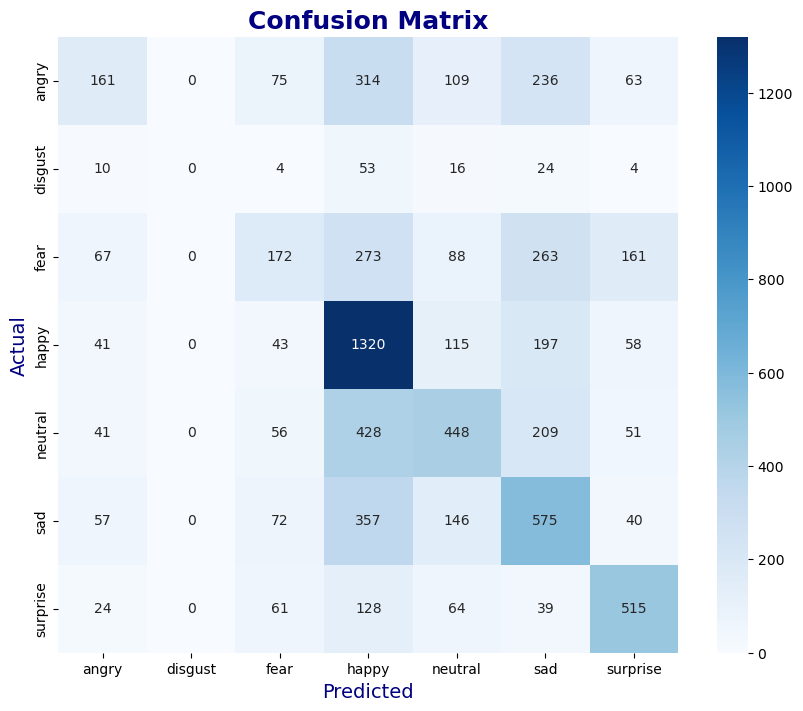

In [34]:
test_acc_vgg16 = evaluate_model(model_vgg, dataloaders['test'], class_names)

**Save the model**

In [35]:
torch.save(model_vgg.state_dict(), './models/vgg16_facial_emotion.pth')

**Plot learning curves**

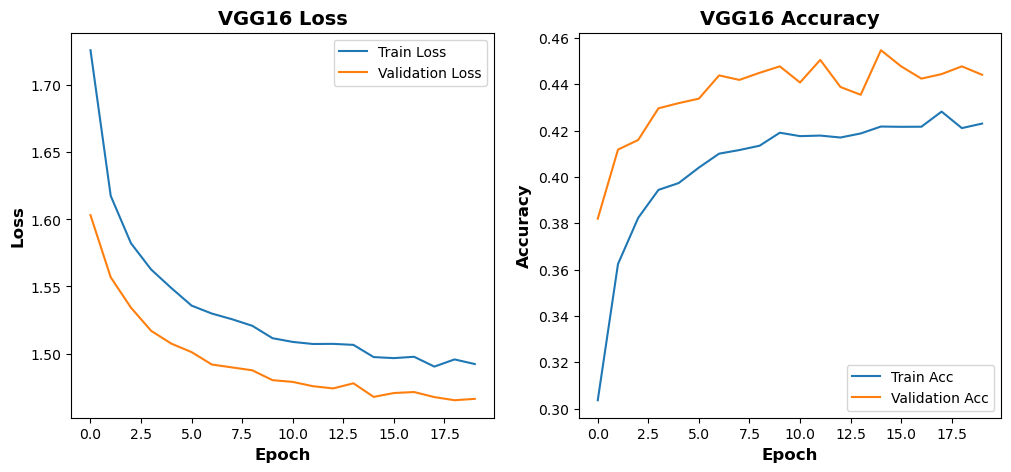

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vgg['train_loss'], label='Train Loss')
plt.plot(history_vgg['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg['train_acc'], label='Train Acc')
plt.plot(history_vgg['val_acc'], label='Validation Acc')
plt.title('VGG16 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

#### DenseNet121

**Initialize DenseNet121**

In [37]:
model_densenet = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\DIP Lab/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [02:12<00:00, 243kB/s]


In [38]:
# Freeze all the layers in DenseNet121
for param in model_densenet.parameters():
    param.requires_grad = False

num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, len(class_names))
model_densenet = model_densenet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_densenet = torch.optim.Adam(model_densenet.parameters(), lr=1e-4)

**Train the model**

In [39]:
model_densenet, history_densenet, train_time_densenet121 = train_model(
    model_densenet, dataloaders, criterion, optimizer_densenet, num_epochs=20
)

Epoch 1/20
----------


train: 100%|██████████| 393/393 [01:54<00:00,  3.43it/s]


Train Loss: 1.7761 Acc: 0.2684


val: 100%|██████████| 57/57 [00:31<00:00,  1.81it/s]


Val Loss: 1.7044 Acc: 0.3204

Epoch 2/20
----------


train: 100%|██████████| 393/393 [01:54<00:00,  3.43it/s]


Train Loss: 1.6707 Acc: 0.3467


val: 100%|██████████| 57/57 [00:31<00:00,  1.83it/s]


Val Loss: 1.6354 Acc: 0.3686

Epoch 3/20
----------


train: 100%|██████████| 393/393 [01:53<00:00,  3.45it/s]


Train Loss: 1.6160 Acc: 0.3801


val: 100%|██████████| 57/57 [00:30<00:00,  1.86it/s]


Val Loss: 1.5973 Acc: 0.3809

Epoch 4/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.41it/s]


Train Loss: 1.5789 Acc: 0.3986


val: 100%|██████████| 57/57 [00:30<00:00,  1.89it/s]


Val Loss: 1.5732 Acc: 0.3982

Epoch 5/20
----------


train: 100%|██████████| 393/393 [02:04<00:00,  3.16it/s]


Train Loss: 1.5547 Acc: 0.4061


val: 100%|██████████| 57/57 [00:30<00:00,  1.87it/s]


Val Loss: 1.5526 Acc: 0.4062

Epoch 6/20
----------


train: 100%|██████████| 393/393 [01:57<00:00,  3.34it/s]


Train Loss: 1.5354 Acc: 0.4152


val: 100%|██████████| 57/57 [00:30<00:00,  1.84it/s]


Val Loss: 1.5378 Acc: 0.4163

Epoch 7/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.39it/s]


Train Loss: 1.5196 Acc: 0.4213


val: 100%|██████████| 57/57 [00:33<00:00,  1.71it/s]


Val Loss: 1.5265 Acc: 0.4171

Epoch 8/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.41it/s]


Train Loss: 1.5065 Acc: 0.4275


val: 100%|██████████| 57/57 [00:31<00:00,  1.84it/s]


Val Loss: 1.5177 Acc: 0.4244

Epoch 9/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]


Train Loss: 1.4947 Acc: 0.4338


val: 100%|██████████| 57/57 [00:31<00:00,  1.82it/s]


Val Loss: 1.5121 Acc: 0.4277

Epoch 10/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.39it/s]


Train Loss: 1.4871 Acc: 0.4364


val: 100%|██████████| 57/57 [00:31<00:00,  1.81it/s]


Val Loss: 1.5048 Acc: 0.4335

Epoch 11/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]


Train Loss: 1.4787 Acc: 0.4396


val: 100%|██████████| 57/57 [00:31<00:00,  1.83it/s]


Val Loss: 1.4989 Acc: 0.4349

Epoch 12/20
----------


train: 100%|██████████| 393/393 [01:57<00:00,  3.36it/s]


Train Loss: 1.4711 Acc: 0.4402


val: 100%|██████████| 57/57 [00:30<00:00,  1.84it/s]


Val Loss: 1.4933 Acc: 0.4386

Epoch 13/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]


Train Loss: 1.4633 Acc: 0.4484


val: 100%|██████████| 57/57 [00:30<00:00,  1.84it/s]


Val Loss: 1.4901 Acc: 0.4369

Epoch 14/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]


Train Loss: 1.4574 Acc: 0.4485


val: 100%|██████████| 57/57 [00:30<00:00,  1.86it/s]


Val Loss: 1.4888 Acc: 0.4305

Epoch 15/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.41it/s]


Train Loss: 1.4544 Acc: 0.4480


val: 100%|██████████| 57/57 [00:30<00:00,  1.86it/s]


Val Loss: 1.4836 Acc: 0.4419

Epoch 16/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.41it/s]


Train Loss: 1.4482 Acc: 0.4503


val: 100%|██████████| 57/57 [00:31<00:00,  1.81it/s]


Val Loss: 1.4790 Acc: 0.4388

Epoch 17/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]


Train Loss: 1.4437 Acc: 0.4523


val: 100%|██████████| 57/57 [00:31<00:00,  1.81it/s]


Val Loss: 1.4797 Acc: 0.4416

Epoch 18/20
----------


train: 100%|██████████| 393/393 [01:56<00:00,  3.36it/s]


Train Loss: 1.4384 Acc: 0.4527


val: 100%|██████████| 57/57 [00:31<00:00,  1.81it/s]


Val Loss: 1.4728 Acc: 0.4422

Epoch 19/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.39it/s]


Train Loss: 1.4366 Acc: 0.4553


val: 100%|██████████| 57/57 [00:31<00:00,  1.82it/s]


Val Loss: 1.4729 Acc: 0.4436

Epoch 20/20
----------


train: 100%|██████████| 393/393 [01:55<00:00,  3.39it/s]


Train Loss: 1.4320 Acc: 0.4554


val: 100%|██████████| 57/57 [00:31<00:00,  1.82it/s]

Val Loss: 1.4694 Acc: 0.4408

Training complete in 49m 7s
Best Validation Acc: 0.4436


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:46<00:00,  2.41it/s]


Test Accuracy: 0.4386


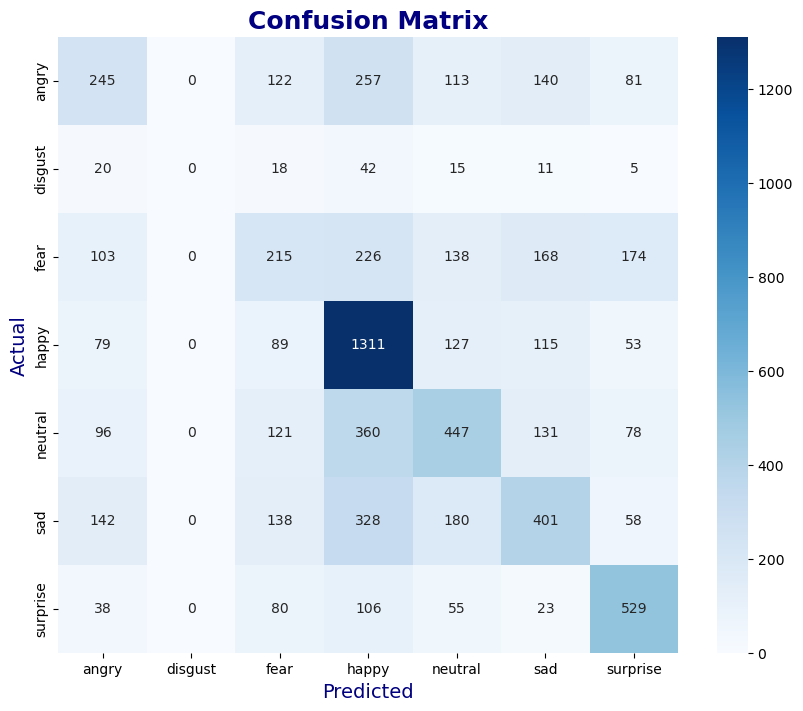

In [40]:
test_acc_densenet121 = evaluate_model(model_densenet, dataloaders['test'], class_names)

**Save the model**

In [41]:
torch.save(model_densenet.state_dict(), './models/densenet121_facial_emotion.pth')

**Plot learning curves**

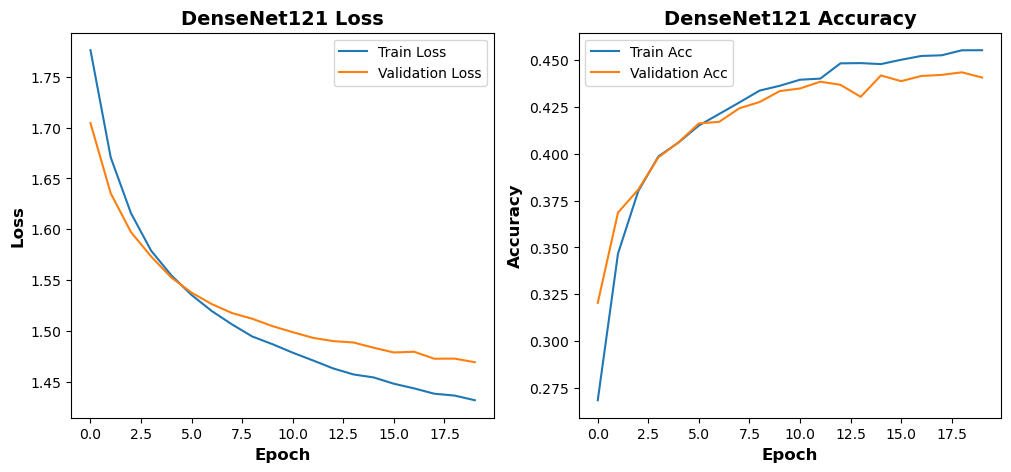

In [42]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_densenet['train_loss'], label='Train Loss')
plt.plot(history_densenet['val_loss'], label='Validation Loss')
plt.title('DenseNet121 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_densenet['train_acc'], label='Train Acc')
plt.plot(history_densenet['val_acc'], label='Validation Acc')
plt.title('DenseNet121 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

---

### Vision Transformer (ViT) Models
We'll use the `vit_b_16` model from `torchvision`.

In [43]:
# Initialize ViT
model_vit = models.vit_b_16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\DIP Lab/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [24:21<00:00, 237kB/s] 


In [45]:
# Freeze all the layers in ViT
for param in model_vit.parameters():
    param.requires_grad = False

# Replace the final classification head to match the number of classes in your dataset
num_ftrs = model_vit.heads[0].in_features
model_vit.heads[0] = nn.Linear(num_ftrs, len(class_names))

# Move model to device (GPU/CPU)
model_vit = model_vit.to(device)

# Define loss function and optimizer (optimizer only affects the classifier head)
criterion = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(model_vit.heads[0].parameters(), lr=1e-4)

**Train the model**

In [46]:
model_vit, history_vit, train_time_vit = train_model(
    model_vit, dataloaders, criterion, optimizer_vit, num_epochs=20
)

Epoch 1/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.6701 Acc: 0.3469


val: 100%|██████████| 57/57 [01:25<00:00,  1.51s/it]


Val Loss: 1.5530 Acc: 0.4037

Epoch 2/20
----------


train: 100%|██████████| 393/393 [07:42<00:00,  1.18s/it]


Train Loss: 1.5072 Acc: 0.4397


val: 100%|██████████| 57/57 [01:26<00:00,  1.52s/it]


Val Loss: 1.4688 Acc: 0.4450

Epoch 3/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.4447 Acc: 0.4683


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.4241 Acc: 0.4581

Epoch 4/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.4059 Acc: 0.4818


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.3913 Acc: 0.4739

Epoch 5/20
----------


train: 100%|██████████| 393/393 [07:38<00:00,  1.17s/it]


Train Loss: 1.3780 Acc: 0.4915


val: 100%|██████████| 57/57 [01:25<00:00,  1.49s/it]


Val Loss: 1.3688 Acc: 0.4857

Epoch 6/20
----------


train: 100%|██████████| 393/393 [07:39<00:00,  1.17s/it]


Train Loss: 1.3563 Acc: 0.4985


val: 100%|██████████| 57/57 [01:25<00:00,  1.49s/it]


Val Loss: 1.3489 Acc: 0.4893

Epoch 7/20
----------


train: 100%|██████████| 393/393 [07:39<00:00,  1.17s/it]


Train Loss: 1.3383 Acc: 0.5048


val: 100%|██████████| 57/57 [01:24<00:00,  1.49s/it]


Val Loss: 1.3365 Acc: 0.4954

Epoch 8/20
----------


train: 100%|██████████| 393/393 [07:37<00:00,  1.17s/it]


Train Loss: 1.3232 Acc: 0.5107


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.3225 Acc: 0.4962

Epoch 9/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.3103 Acc: 0.5139


val: 100%|██████████| 57/57 [01:25<00:00,  1.51s/it]


Val Loss: 1.3110 Acc: 0.5015

Epoch 10/20
----------


train: 100%|██████████| 393/393 [07:41<00:00,  1.17s/it]


Train Loss: 1.2986 Acc: 0.5185


val: 100%|██████████| 57/57 [01:25<00:00,  1.51s/it]


Val Loss: 1.3023 Acc: 0.5052

Epoch 11/20
----------


train: 100%|██████████| 393/393 [07:37<00:00,  1.17s/it]


Train Loss: 1.2890 Acc: 0.5235


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.2937 Acc: 0.5079

Epoch 12/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.2797 Acc: 0.5270


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.2866 Acc: 0.5146

Epoch 13/20
----------


train: 100%|██████████| 393/393 [07:41<00:00,  1.17s/it]


Train Loss: 1.2715 Acc: 0.5301


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.2819 Acc: 0.5169

Epoch 14/20
----------


train: 100%|██████████| 393/393 [07:39<00:00,  1.17s/it]


Train Loss: 1.2642 Acc: 0.5321


val: 100%|██████████| 57/57 [01:24<00:00,  1.49s/it]


Val Loss: 1.2737 Acc: 0.5210

Epoch 15/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.2575 Acc: 0.5350


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.2682 Acc: 0.5233

Epoch 16/20
----------


train: 100%|██████████| 393/393 [07:38<00:00,  1.17s/it]


Train Loss: 1.2508 Acc: 0.5381


val: 100%|██████████| 57/57 [01:22<00:00,  1.45s/it]


Val Loss: 1.2641 Acc: 0.5249

Epoch 17/20
----------


train: 100%|██████████| 393/393 [07:25<00:00,  1.13s/it]


Train Loss: 1.2453 Acc: 0.5390


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.2573 Acc: 0.5272

Epoch 18/20
----------


train: 100%|██████████| 393/393 [07:41<00:00,  1.17s/it]


Train Loss: 1.2397 Acc: 0.5422


val: 100%|██████████| 57/57 [01:26<00:00,  1.51s/it]


Val Loss: 1.2566 Acc: 0.5272

Epoch 19/20
----------


train: 100%|██████████| 393/393 [07:41<00:00,  1.17s/it]


Train Loss: 1.2344 Acc: 0.5439


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]


Val Loss: 1.2519 Acc: 0.5339

Epoch 20/20
----------


train: 100%|██████████| 393/393 [07:40<00:00,  1.17s/it]


Train Loss: 1.2299 Acc: 0.5473


val: 100%|██████████| 57/57 [01:25<00:00,  1.50s/it]

Val Loss: 1.2481 Acc: 0.5305

Training complete in 181m 35s
Best Validation Acc: 0.5339


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [02:34<00:00,  1.36s/it]


Test Accuracy: 0.5222


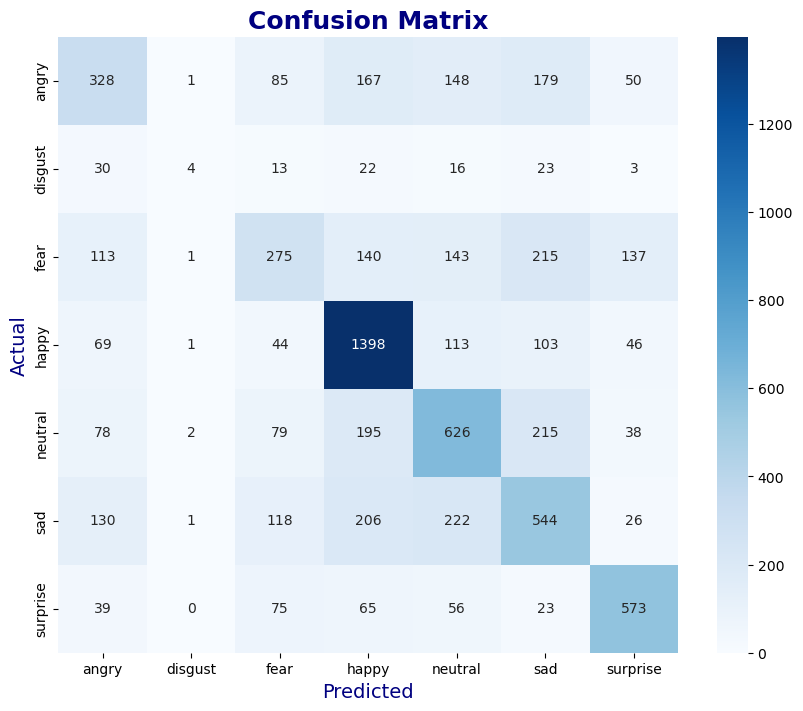

In [47]:
test_acc_vit = evaluate_model(model_vit, dataloaders['test'], class_names)

**Save the model**

In [48]:
torch.save(model_vit.state_dict(), './models/vit_b_16_facial_emotion.pth')

**Plot learning curves**

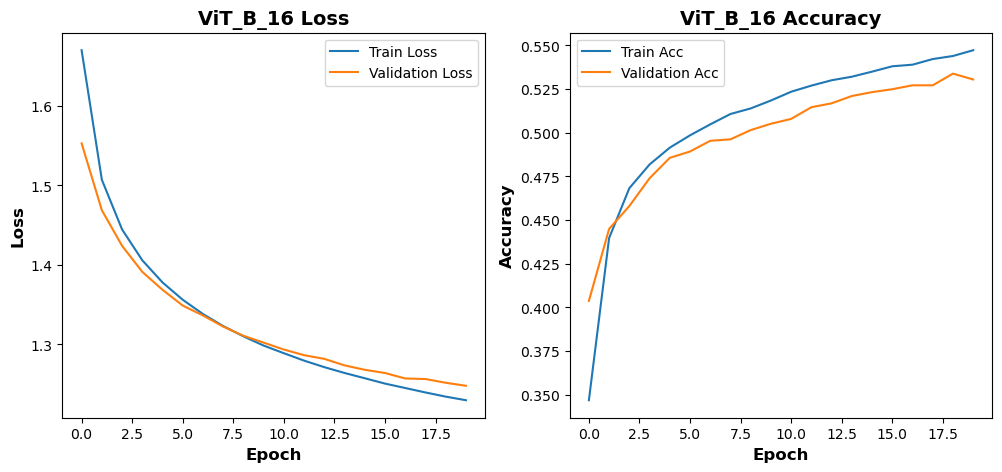

In [49]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vit['train_loss'], label='Train Loss')
plt.plot(history_vit['val_loss'], label='Validation Loss')
plt.title('ViT_B_16 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vit['train_acc'], label='Train Acc')
plt.plot(history_vit['val_acc'], label='Validation Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('ViT_B_16 Accuracy', fontweight='bold', fontsize=14)

plt.show()

---

### CLIP Models
We'll use OpenAI's CLIP model via `openai/clip` package. Note that CLIP is primarily designed for image-text tasks, but we can adapt it for classification.

In [3]:
# Install CLIP
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\dip lab\appdata\local\temp\pip-req-build-f74v885b
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\DIP Lab\AppData\Local\Temp\pip-req-build-f74v885b'


In [22]:
import clip

# Load CLIP model
model_clip, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [01:58<00:00, 3.00MiB/s]


In [23]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        
        # Freeze the CLIP model parameters (feature extraction)
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        self.fc = nn.Linear(clip_model.visual.output_dim, num_classes)

    def forward(self, x):
        # Get image features from CLIP
        with torch.no_grad():
            image_features = self.clip_model.encode_image(x)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Convert to float32 if it's in half precision
        if image_features.dtype == torch.float16:
            image_features = image_features.float()

        # Pass through classification head
        out = self.fc(image_features)
        return out

**Initialize CLIP-based classifier**

In [24]:
model_clip_classifier = CLIPClassifier(model_clip, len(class_names))
model_clip_classifier = model_clip_classifier.to(device)

In [25]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_clip = torch.optim.Adam(model_clip_classifier.fc.parameters(), lr=1e-4)

**Train the model**

In [26]:
model_clip_classifier, history_clip, train_time_clip = train_model(
    model_clip_classifier, dataloaders, criterion, optimizer_clip, num_epochs=20
)

Epoch 1/20
----------


train: 100%|██████████| 393/393 [06:29<00:00,  1.01it/s]


Train Loss: 1.8905 Acc: 0.2654


val: 100%|██████████| 57/57 [01:04<00:00,  1.13s/it]


Val Loss: 1.8461 Acc: 0.2572

Epoch 2/20
----------


train: 100%|██████████| 393/393 [01:34<00:00,  4.16it/s]


Train Loss: 1.8077 Acc: 0.2678


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.7783 Acc: 0.2639

Epoch 3/20
----------


train: 100%|██████████| 393/393 [01:27<00:00,  4.51it/s]


Train Loss: 1.7477 Acc: 0.2818


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.7257 Acc: 0.2901

Epoch 4/20
----------


train: 100%|██████████| 393/393 [01:27<00:00,  4.49it/s]


Train Loss: 1.6994 Acc: 0.3129


val: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


Val Loss: 1.6815 Acc: 0.3215

Epoch 5/20
----------


train: 100%|██████████| 393/393 [01:26<00:00,  4.52it/s]


Train Loss: 1.6583 Acc: 0.3534


val: 100%|██████████| 57/57 [00:28<00:00,  1.97it/s]


Val Loss: 1.6430 Acc: 0.3711

Epoch 6/20
----------


train: 100%|██████████| 393/393 [01:26<00:00,  4.53it/s]


Train Loss: 1.6219 Acc: 0.3986


val: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


Val Loss: 1.6085 Acc: 0.4188

Epoch 7/20
----------


train: 100%|██████████| 393/393 [01:27<00:00,  4.50it/s]


Train Loss: 1.5892 Acc: 0.4343


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.5772 Acc: 0.4508

Epoch 8/20
----------


train: 100%|██████████| 393/393 [01:26<00:00,  4.55it/s]


Train Loss: 1.5594 Acc: 0.4648


val: 100%|██████████| 57/57 [00:28<00:00,  1.97it/s]


Val Loss: 1.5487 Acc: 0.4742

Epoch 9/20
----------


train: 100%|██████████| 393/393 [01:27<00:00,  4.51it/s]


Train Loss: 1.5321 Acc: 0.4844


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.5224 Acc: 0.4898

Epoch 10/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.43it/s]


Train Loss: 1.5068 Acc: 0.5020


val: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


Val Loss: 1.4981 Acc: 0.4999

Epoch 11/20
----------


train: 100%|██████████| 393/393 [01:27<00:00,  4.48it/s]


Train Loss: 1.4834 Acc: 0.5124


val: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


Val Loss: 1.4754 Acc: 0.5135

Epoch 12/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.45it/s]


Train Loss: 1.4615 Acc: 0.5230


val: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


Val Loss: 1.4543 Acc: 0.5208

Epoch 13/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.45it/s]


Train Loss: 1.4411 Acc: 0.5323


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.4344 Acc: 0.5291

Epoch 14/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.45it/s]


Train Loss: 1.4219 Acc: 0.5395


val: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


Val Loss: 1.4159 Acc: 0.5339

Epoch 15/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.42it/s]


Train Loss: 1.4039 Acc: 0.5449


val: 100%|██████████| 57/57 [00:28<00:00,  1.98it/s]


Val Loss: 1.3985 Acc: 0.5405

Epoch 16/20
----------


train: 100%|██████████| 393/393 [01:29<00:00,  4.40it/s]


Train Loss: 1.3869 Acc: 0.5510


val: 100%|██████████| 57/57 [00:27<00:00,  2.05it/s]


Val Loss: 1.3821 Acc: 0.5428

Epoch 17/20
----------


train: 100%|██████████| 393/393 [01:26<00:00,  4.53it/s]


Train Loss: 1.3709 Acc: 0.5544


val: 100%|██████████| 57/57 [00:27<00:00,  2.07it/s]


Val Loss: 1.3665 Acc: 0.5478

Epoch 18/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.43it/s]


Train Loss: 1.3558 Acc: 0.5590


val: 100%|██████████| 57/57 [00:26<00:00,  2.11it/s]


Val Loss: 1.3519 Acc: 0.5500

Epoch 19/20
----------


train: 100%|██████████| 393/393 [01:26<00:00,  4.55it/s]


Train Loss: 1.3415 Acc: 0.5636


val: 100%|██████████| 57/57 [00:27<00:00,  2.09it/s]


Val Loss: 1.3381 Acc: 0.5517

Epoch 20/20
----------


train: 100%|██████████| 393/393 [01:27<00:00,  4.50it/s]


Train Loss: 1.3280 Acc: 0.5663


val: 100%|██████████| 57/57 [00:27<00:00,  2.11it/s]

Val Loss: 1.3249 Acc: 0.5539

Training complete in 44m 33s
Best Validation Acc: 0.5539


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:58<00:00,  1.92it/s]


Test Accuracy: 0.5536


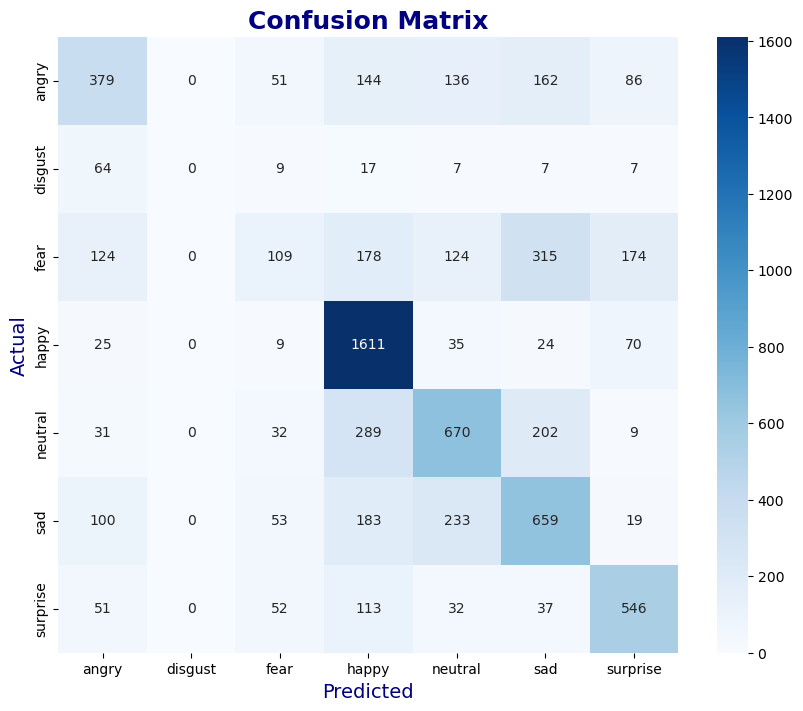

In [27]:
test_acc_clip = evaluate_model(model_clip_classifier, dataloaders['test'], class_names)

**Save the model**

In [28]:
torch.save(model_clip_classifier.state_dict(), './models/clip_classifier_facial_emotion.pth')

**Plot learning curves**

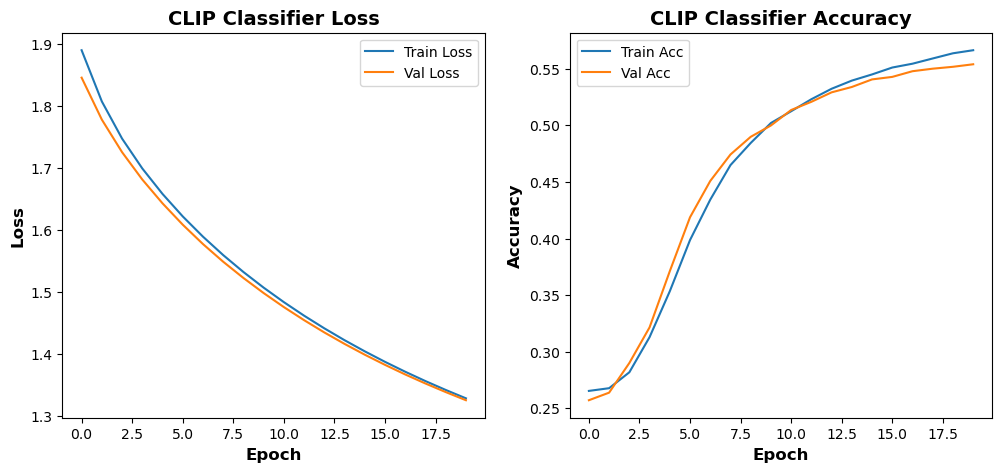

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_clip['train_loss'], label='Train Loss')
plt.plot(history_clip['val_loss'], label='Val Loss')
plt.title('CLIP Classifier Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_clip['train_acc'], label='Train Acc')
plt.plot(history_clip['val_acc'], label='Val Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('CLIP Classifier Accuracy', fontweight='bold', fontsize=14)

plt.show()


## Hybrid Model: CLIP with ResNet Backbone
Here, we'll use a pre-trained CLIP model with ResNet as the image encoder.

In [31]:
# Define a custom classifier that uses the CLIP model with ResNet backbone as a feature extractor
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        # Freeze the CLIP model parameters (feature extraction)
        for param in self.clip_model.parameters():
            param.requires_grad = False
        # Define the classification head
        self.classifier = nn.Linear(clip_model.visual.output_dim, num_classes)

    def forward(self, image):
        with torch.no_grad():  # Ensure the CLIP model is not trained
            features = self.clip_model.encode_image(image)
            features /= features.norm(dim=-1, keepdim=True)
        
        # Pass through the classification head
        output = self.classifier(features.float())
        return output

In [32]:
# For ResNet-based CLIP
model_clip_resnet, preprocess_resnet = clip.load("RN50", device=device)
classifier_resnet = CLIPClassifier(model_clip_resnet, len(class_names)).to(device)

100%|████████████████████████████████████████| 244M/244M [17:42<00:00, 241kiB/s]


In [33]:
# Update dataloaders with correct preprocessing
train_dataset.transform = preprocess_resnet
val_dataset.transform = preprocess_resnet  
test_dataset.transform = preprocess_resnet 

In [34]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

In [35]:
optimizer = Adam(classifier_resnet.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

**Train the model**

In [36]:
classifier_resnet, history_resnet_clip, train_time_clip_res = train_model(classifier_resnet, dataloaders, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------


train: 100%|██████████| 393/393 [02:25<00:00,  2.70it/s]


Train Loss: 1.9355 Acc: 0.2514


val: 100%|██████████| 57/57 [00:28<00:00,  1.98it/s]


Val Loss: 1.9319 Acc: 0.2430

Epoch 2/20
----------


train: 100%|██████████| 393/393 [01:42<00:00,  3.83it/s]


Train Loss: 1.9267 Acc: 0.2525


val: 100%|██████████| 57/57 [00:30<00:00,  1.90it/s]


Val Loss: 1.9238 Acc: 0.2432

Epoch 3/20
----------


train: 100%|██████████| 393/393 [01:43<00:00,  3.80it/s]


Train Loss: 1.9182 Acc: 0.2524


val: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


Val Loss: 1.9159 Acc: 0.2435

Epoch 4/20
----------


train: 100%|██████████| 393/393 [01:43<00:00,  3.81it/s]


Train Loss: 1.9104 Acc: 0.2524


val: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


Val Loss: 1.9086 Acc: 0.2441

Epoch 5/20
----------


train: 100%|██████████| 393/393 [01:43<00:00,  3.79it/s]


Train Loss: 1.9028 Acc: 0.2523


val: 100%|██████████| 57/57 [00:30<00:00,  1.89it/s]


Val Loss: 1.9015 Acc: 0.2441

Epoch 6/20
----------


train: 100%|██████████| 393/393 [01:44<00:00,  3.76it/s]


Train Loss: 1.8957 Acc: 0.2523


val: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


Val Loss: 1.8948 Acc: 0.2441

Epoch 7/20
----------


train: 100%|██████████| 393/393 [01:44<00:00,  3.75it/s]


Train Loss: 1.8889 Acc: 0.2523


val: 100%|██████████| 57/57 [00:30<00:00,  1.88it/s]


Val Loss: 1.8887 Acc: 0.2441

Epoch 8/20
----------


train: 100%|██████████| 393/393 [01:44<00:00,  3.76it/s]


Train Loss: 1.8826 Acc: 0.2523


val: 100%|██████████| 57/57 [00:29<00:00,  1.91it/s]


Val Loss: 1.8827 Acc: 0.2441

Epoch 9/20
----------


train: 100%|██████████| 393/393 [01:43<00:00,  3.79it/s]


Train Loss: 1.8765 Acc: 0.2523


val: 100%|██████████| 57/57 [00:29<00:00,  1.93it/s]


Val Loss: 1.8772 Acc: 0.2441

Epoch 10/20
----------


train: 100%|██████████| 393/393 [01:45<00:00,  3.73it/s]


Train Loss: 1.8707 Acc: 0.2523


val: 100%|██████████| 57/57 [00:29<00:00,  1.91it/s]


Val Loss: 1.8716 Acc: 0.2441

Epoch 11/20
----------


train: 100%|██████████| 393/393 [01:47<00:00,  3.66it/s]


Train Loss: 1.8653 Acc: 0.2523


val: 100%|██████████| 57/57 [00:30<00:00,  1.90it/s]


Val Loss: 1.8667 Acc: 0.2441

Epoch 12/20
----------


train: 100%|██████████| 393/393 [01:44<00:00,  3.76it/s]


Train Loss: 1.8600 Acc: 0.2523


val: 100%|██████████| 57/57 [00:33<00:00,  1.71it/s]


Val Loss: 1.8616 Acc: 0.2441

Epoch 13/20
----------


train: 100%|██████████| 393/393 [01:46<00:00,  3.69it/s]


Train Loss: 1.8549 Acc: 0.2523


val: 100%|██████████| 57/57 [00:31<00:00,  1.80it/s]


Val Loss: 1.8570 Acc: 0.2441

Epoch 14/20
----------


train: 100%|██████████| 393/393 [01:46<00:00,  3.68it/s]


Train Loss: 1.8502 Acc: 0.2523


val: 100%|██████████| 57/57 [00:31<00:00,  1.82it/s]


Val Loss: 1.8526 Acc: 0.2441

Epoch 15/20
----------


train: 100%|██████████| 393/393 [01:46<00:00,  3.70it/s]


Train Loss: 1.8456 Acc: 0.2523


val: 100%|██████████| 57/57 [00:30<00:00,  1.89it/s]


Val Loss: 1.8484 Acc: 0.2441

Epoch 16/20
----------


train: 100%|██████████| 393/393 [01:47<00:00,  3.66it/s]


Train Loss: 1.8413 Acc: 0.2524


val: 100%|██████████| 57/57 [00:32<00:00,  1.77it/s]


Val Loss: 1.8445 Acc: 0.2441

Epoch 17/20
----------


train: 100%|██████████| 393/393 [01:45<00:00,  3.74it/s]


Train Loss: 1.8372 Acc: 0.2523


val: 100%|██████████| 57/57 [00:29<00:00,  1.90it/s]


Val Loss: 1.8405 Acc: 0.2441

Epoch 18/20
----------


train: 100%|██████████| 393/393 [01:45<00:00,  3.73it/s]


Train Loss: 1.8332 Acc: 0.2523


val: 100%|██████████| 57/57 [00:29<00:00,  1.91it/s]


Val Loss: 1.8368 Acc: 0.2441

Epoch 19/20
----------


train: 100%|██████████| 393/393 [01:44<00:00,  3.75it/s]


Train Loss: 1.8294 Acc: 0.2523


val: 100%|██████████| 57/57 [00:30<00:00,  1.85it/s]


Val Loss: 1.8334 Acc: 0.2441

Epoch 20/20
----------


train: 100%|██████████| 393/393 [01:44<00:00,  3.78it/s]


Train Loss: 1.8258 Acc: 0.2523


val: 100%|██████████| 57/57 [00:30<00:00,  1.89it/s]

Val Loss: 1.8302 Acc: 0.2441

Training complete in 45m 46s
Best Validation Acc: 0.2441


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:45<00:00,  2.48it/s]


Test Accuracy: 0.2474


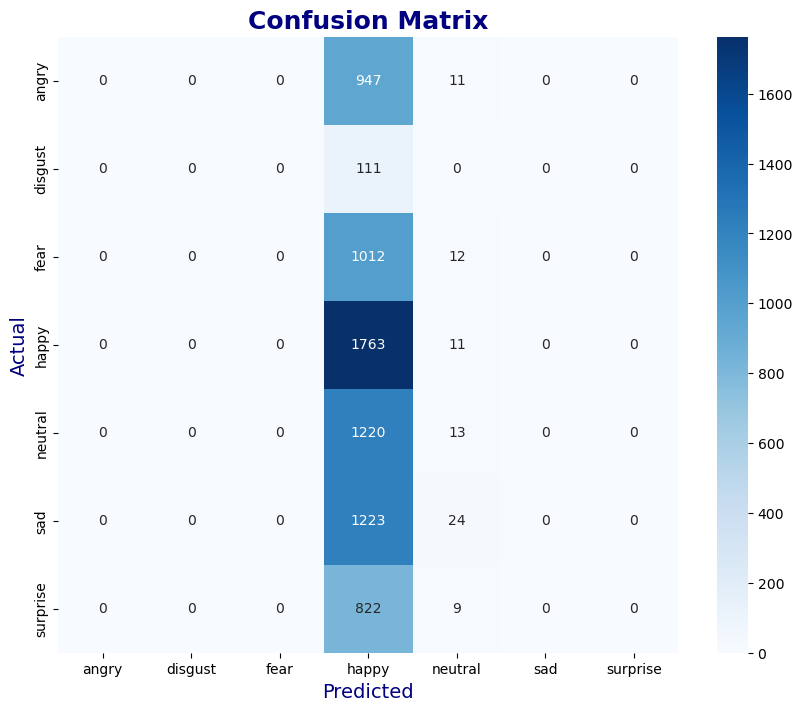

In [37]:
test_acc_clip_resnet = evaluate_model(classifier_resnet, dataloaders['test'], class_names)

**Save the model**

In [38]:
torch.save(classifier_resnet.state_dict(), './models/resnet_clip_classifier_fer.pth')

**Plot learning curves**

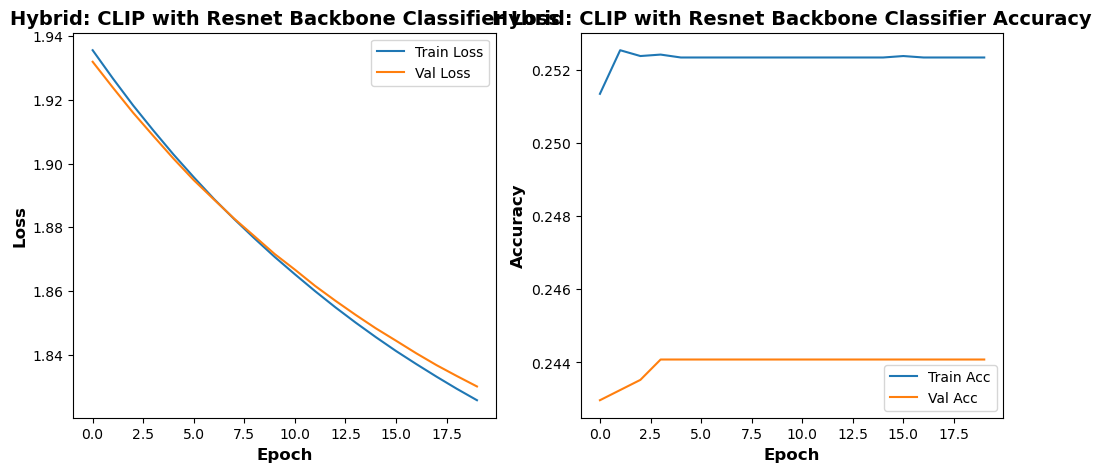

In [49]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_resnet_clip['train_loss'], label='Train Loss') 
plt.plot(history_resnet_clip['val_loss'], label='Val Loss')
plt.title('Hybrid: CLIP with Resnet Backbone Classifier Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet_clip['train_acc'], label='Train Acc')
plt.plot(history_resnet_clip['val_acc'], label='Val Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('Hybrid: CLIP with Resnet Backbone Classifier Accuracy', fontweight='bold', fontsize=14)

plt.show()

---

### Hybrid Model: CLIP with Vision Transformer (ViT)
We load CLIP with a ViT backbone and fine-tune it on the same dataset.

In [40]:
# Define a custom classifier that uses the CLIP model with ViT backbone as a feature extractor
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        
        # Freeze the CLIP model parameters (feature extraction)
        for param in self.clip_model.parameters():
            param.requires_grad = False
        
        # Define the classification head
        self.classifier = nn.Linear(clip_model.visual.output_dim, num_classes)

    def forward(self, image):
        with torch.no_grad():  # Ensure the CLIP model is not trained
            features = self.clip_model.encode_image(image)
            features /= features.norm(dim=-1, keepdim=True)
        
        # Pass through the classification head
        output = self.classifier(features.float())
        return output

**Load the CLIP model with ViT backbone**  
**For ViT-based CLIP**

In [41]:
model_clip_vit, preprocess_vit = clip.load("ViT-B/32", device=device)
classifier_vit = CLIPClassifier(model_clip_vit, len(class_names)).to(device)

In [42]:
# Adjust the preprocessing to use CLIP's transformation for ViT
train_dataset.transform = preprocess_vit
val_dataset.transform = preprocess_vit
test_dataset.transform = preprocess_vit

# Dataloaders with updated transforms for ViT
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

In [43]:
optimizer = Adam(classifier_vit.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

**Train the CLIP-ViT model**

In [44]:
classifier_vit, history_vit_clip, train_time_clip_vit = train_model(classifier_vit, dataloaders, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------


train: 100%|██████████| 393/393 [01:29<00:00,  4.38it/s]


Train Loss: 1.9409 Acc: 0.2102


val: 100%|██████████| 57/57 [00:28<00:00,  1.97it/s]


Val Loss: 1.9355 Acc: 0.2460

Epoch 2/20
----------


train: 100%|██████████| 393/393 [01:30<00:00,  4.35it/s]


Train Loss: 1.9291 Acc: 0.2746


val: 100%|██████████| 57/57 [00:28<00:00,  2.00it/s]


Val Loss: 1.9243 Acc: 0.2614

Epoch 3/20
----------


train: 100%|██████████| 393/393 [01:32<00:00,  4.26it/s]


Train Loss: 1.9179 Acc: 0.2739


val: 100%|██████████| 57/57 [00:28<00:00,  1.98it/s]


Val Loss: 1.9135 Acc: 0.2569

Epoch 4/20
----------


train: 100%|██████████| 393/393 [01:31<00:00,  4.31it/s]


Train Loss: 1.9071 Acc: 0.2654


val: 100%|██████████| 57/57 [00:28<00:00,  1.99it/s]


Val Loss: 1.9032 Acc: 0.2524

Epoch 5/20
----------


train: 100%|██████████| 393/393 [01:30<00:00,  4.34it/s]


Train Loss: 1.8967 Acc: 0.2607


val: 100%|██████████| 57/57 [00:28<00:00,  1.99it/s]


Val Loss: 1.8932 Acc: 0.2488

Epoch 6/20
----------


train: 100%|██████████| 393/393 [01:31<00:00,  4.28it/s]


Train Loss: 1.8867 Acc: 0.2587


val: 100%|██████████| 57/57 [00:29<00:00,  1.93it/s]


Val Loss: 1.8837 Acc: 0.2471

Epoch 7/20
----------


train: 100%|██████████| 393/393 [01:31<00:00,  4.31it/s]


Train Loss: 1.8771 Acc: 0.2574


val: 100%|██████████| 57/57 [00:28<00:00,  1.97it/s]


Val Loss: 1.8744 Acc: 0.2474

Epoch 8/20
----------


train: 100%|██████████| 393/393 [02:08<00:00,  3.05it/s]


Train Loss: 1.8678 Acc: 0.2568


val: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


Val Loss: 1.8655 Acc: 0.2471

Epoch 9/20
----------


train: 100%|██████████| 393/393 [02:24<00:00,  2.72it/s]


Train Loss: 1.8588 Acc: 0.2563


val: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


Val Loss: 1.8568 Acc: 0.2471

Epoch 10/20
----------


train: 100%|██████████| 393/393 [01:31<00:00,  4.31it/s]


Train Loss: 1.8501 Acc: 0.2560


val: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


Val Loss: 1.8484 Acc: 0.2469

Epoch 11/20
----------


train: 100%|██████████| 393/393 [01:29<00:00,  4.37it/s]


Train Loss: 1.8417 Acc: 0.2558


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.8403 Acc: 0.2471

Epoch 12/20
----------


train: 100%|██████████| 393/393 [01:30<00:00,  4.36it/s]


Train Loss: 1.8336 Acc: 0.2558


val: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Val Loss: 1.8324 Acc: 0.2474

Epoch 13/20
----------


train: 100%|██████████| 393/393 [01:31<00:00,  4.28it/s]


Train Loss: 1.8256 Acc: 0.2558


val: 100%|██████████| 57/57 [00:30<00:00,  1.90it/s]


Val Loss: 1.8248 Acc: 0.2474

Epoch 14/20
----------


train: 100%|██████████| 393/393 [01:34<00:00,  4.18it/s]


Train Loss: 1.8180 Acc: 0.2563


val: 100%|██████████| 57/57 [00:30<00:00,  1.86it/s]


Val Loss: 1.8173 Acc: 0.2480

Epoch 15/20
----------


train: 100%|██████████| 393/393 [01:32<00:00,  4.26it/s]


Train Loss: 1.8105 Acc: 0.2569


val: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


Val Loss: 1.8101 Acc: 0.2491

Epoch 16/20
----------


train: 100%|██████████| 393/393 [01:29<00:00,  4.40it/s]


Train Loss: 1.8033 Acc: 0.2573


val: 100%|██████████| 57/57 [00:27<00:00,  2.10it/s]


Val Loss: 1.8031 Acc: 0.2494

Epoch 17/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.42it/s]


Train Loss: 1.7962 Acc: 0.2575


val: 100%|██████████| 57/57 [00:28<00:00,  2.01it/s]


Val Loss: 1.7963 Acc: 0.2494

Epoch 18/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.45it/s]


Train Loss: 1.7894 Acc: 0.2582


val: 100%|██████████| 57/57 [00:28<00:00,  2.02it/s]


Val Loss: 1.7896 Acc: 0.2499

Epoch 19/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.45it/s]


Train Loss: 1.7827 Acc: 0.2592


val: 100%|██████████| 57/57 [00:27<00:00,  2.05it/s]


Val Loss: 1.7831 Acc: 0.2505

Epoch 20/20
----------


train: 100%|██████████| 393/393 [01:28<00:00,  4.43it/s]


Train Loss: 1.7762 Acc: 0.2602


val: 100%|██████████| 57/57 [00:27<00:00,  2.06it/s]

Val Loss: 1.7768 Acc: 0.2510

Training complete in 41m 21s
Best Validation Acc: 0.2614


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:39<00:00,  2.84it/s]


Test Accuracy: 0.2548


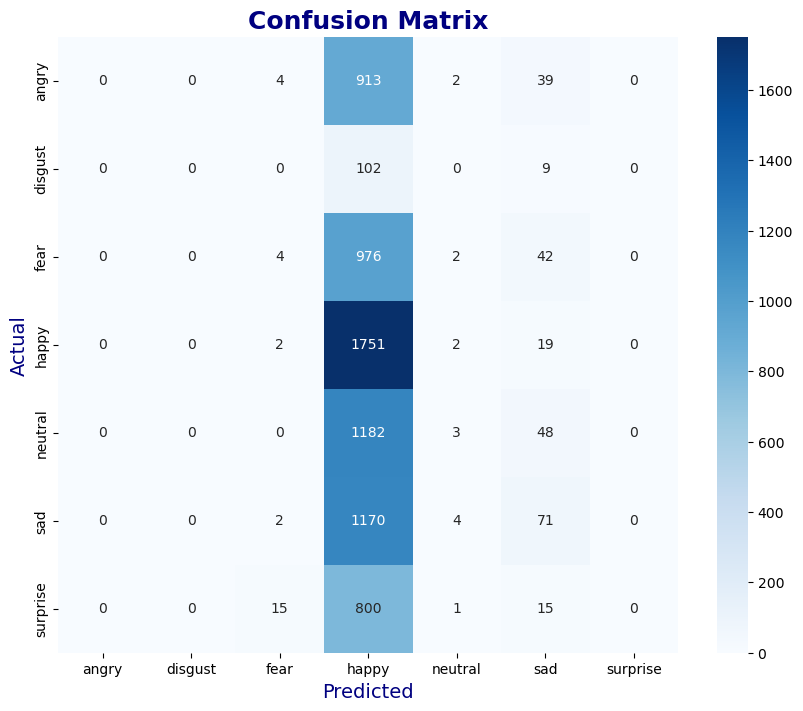

In [50]:
test_acc_clip_vit = evaluate_model(classifier_vit, dataloaders['test'], class_names)

**Save the model**

In [46]:
torch.save(classifier_vit.state_dict(), './models/vit_clip_classifier_fer.pth')

**Plot learning curves**

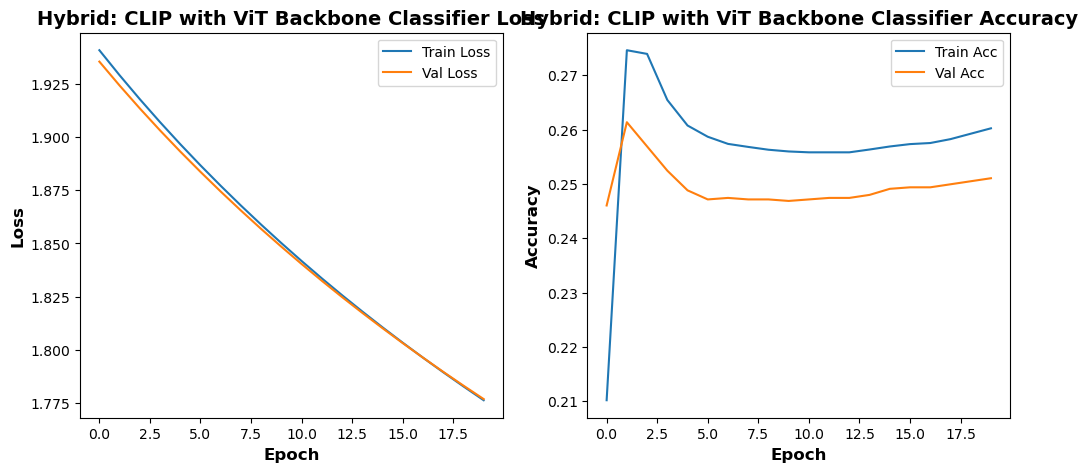

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vit_clip['train_loss'], label='Train Loss') 
plt.plot(history_vit_clip['val_loss'], label='Val Loss')
plt.title('Hybrid: CLIP with ViT Backbone Classifier Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vit_clip['train_acc'], label='Train Acc')
plt.plot(history_vit_clip['val_acc'], label='Val Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('Hybrid: CLIP with ViT Backbone Classifier Accuracy', fontweight='bold', fontsize=14)

plt.show()

---

**Models Comparison**

In [54]:
results = {
    'Model': ['ResNet18', 'VGG16', 'DesnseNet121', 'ViT (vit_b_16)', 'CLIP (ViT-B/32)', 'CLIP with resnet', 'CLIP with ViT'],
    'Accuracy': [
        test_acc_resnet18,
        test_acc_vgg16,
        test_acc_densenet121,
        test_acc_vit,
        test_acc_clip,
        test_acc_clip_resnet,
        test_acc_clip_vit
    ],
    'Training Time': [
        train_time_resnet18,
        train_time_vgg16,
        train_time_densenet121,
        train_time_vit,
        train_time_clip,
        train_time_clip_res,
        train_time_clip_vit
    ]
}

In [56]:
import pandas as pd
# Create DataFrame
df = pd.DataFrame(results)
print(df.to_string(index=False))

           Model  Accuracy  Training Time
        ResNet18  0.432400    2127.000000
           VGG16  0.444600    3542.000000
    DesnseNet121  0.438600    2947.000000
  ViT (vit_b_16)  0.533900   10895.000000
 CLIP (ViT-B/32)  0.553636    2672.647319
CLIP with resnet  0.247423    2746.025794
   CLIP with ViT  0.254806    2481.448090


**Bar chart for accuracy comparison**

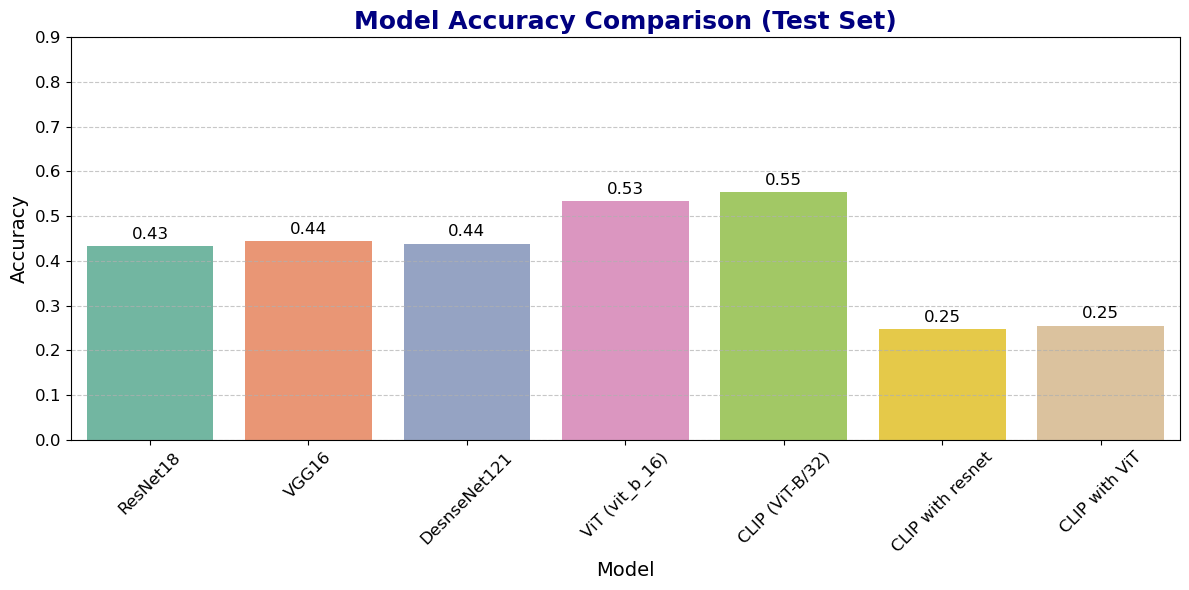

In [60]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Accuracy', palette='Set2')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of each bar
for index, value in enumerate(df['Accuracy']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Model Accuracy Comparison (Test Set)', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.0, 0.9)
plt.tight_layout()
plt.show()

**Line Plot for Models Accuracy Comparison**  
Interactive Line Plot for Models Accuracy Comparison

In [58]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

# Add line and markers
fig.add_trace(go.Scatter(x=df['Model'], y=df['Accuracy'],
                         mode='lines+markers',
                         line=dict(width=2, color='royalblue'),
                         marker=dict(size=10, color='darkblue', line=dict(width=2, color='black')),
                         name='Accuracy'))

# Fill area under the line
fig.add_trace(go.Scatter(x=df['Model'], y=df['Accuracy'],
                         mode='lines',
                         fill='tozeroy',  # Fill to zero
                         fillcolor='rgba(173, 216, 230, 0.5)',  # Light blue fill
                         line=dict(color='rgba(255, 255, 255, 0)'),  # Invisible line
                         showlegend=False))

fig.update_layout(title='Model Accuracy Comparison',
                  title_font=dict(size=20, family='Arial, sans-serif', color='navy'),
                  xaxis_title='Model',
                  yaxis_title='Accuracy',
                  yaxis=dict(range=[0.0, 0.9]),
                  xaxis_tickangle=-45,
                  template='plotly_white',
                  font=dict(size=14))

fig.show()

**Bar plot for training time**

In [59]:
# Convert seconds to minutes:seconds format
df['Training Time (m:s)'] = df['Training Time'].apply(lambda x: f"{int(x // 60)}:{int(x % 60):02d}")

# Create the interactive bar chart
fig = go.Figure(data=[go.Bar(
    x=df['Model'],
    y=df['Training Time'],
    text=df['Training Time (m:s)'],
    textposition='auto',
    hoverinfo='text',
    marker_color=px.colors.qualitative.Plotly
)])

fig.update_layout(
    title='Model Training Time Comparison',
    xaxis_title='Model',
    yaxis_title='Training Time (seconds)',
    font=dict(size=14)
)
fig.show()

---